In [101]:
%matplotlib inline

import matplotlib.pyplot as plt
import random
import math
import numpy as np

In [102]:
# parameters for group effect
g1 = 2
g2 = 2
g3 = 0.5

# model parameters
sigma = 0.5
beta = 1

In [134]:
def mle(observations):
    max_x = [0, 0, 0, 0, 0] 
    max_likelihood = 0
    low = 3
    ceiling = 9
    for i1 in range(low, ceiling):
        for i2 in range(low, ceiling):
            for i3 in range(low, ceiling):
                for i4 in range(low, ceiling):
                    for i5 in range(low, ceiling):
                        params = [float(i1), float(i2), float(i3), float(i4), float(i5)]
                        
                        current_val = likelihood_val(params, observations) 
                        
                        current_val = current_val * normal_pdf(5, 2, i1) * normal_pdf(5, 2, i2) * normal_pdf(5, 2, i3) * normal_pdf(5, 2, i4) * normal_pdf(5, 2, i5) 
                            
                        if current_val > max_likelihood:
                            max_x = params
                            max_likelihood = current_val
    return max_x

def normal_pdf(mean, var, val):
    return 1.0/(2 * var * np.pi)**0.5 * np.exp(-(val - mean)**2/(2 * var))

def likelihood_val(params, observations):
    product = 1.0
    
    # get softmax denom
    sm_sum = 0.0
    for i in range(0, len(params)):
        sm_sum += np.exp(params[i]/10)
        
    for i in range(0, len(params)):
        likelihood_softmax = np.exp(params[i]/10)
        product *= (likelihood_softmax/sm_sum)**(observations[i])
    
    return product
        
def decision_vals(t, weight):
    x = t[0]
    expected = x[0]
    return (expected)

def softmax(x):
    prob_t = [0,0,0,0,0]      
    for a in range(0, 5):
        prob_t[a] = np.exp(x[a]/7)
    prob_t = np.true_divide(prob_t,sum(prob_t))
    return prob_t

def prob_index(probs):
    r = random.random()
    index = 0
    while(r >= 0 and index < len(probs)):
        r -= probs[index]
        index += 1
    return index - 1

def generate_sample(index, underlying):
    dist = underlying[index]
    reward = np.random.normal(dist[0], 1.0)
    return reward

def update_dist(index, hyperparams, reward, underlying):
    dist = hyperparams[index]
    real = underlying[index]
    new_mean = (dist[0]/dist[1] + reward/real[1])/(1/dist[1] + 1/real[1])
    new_var = (1/dist[1] + 1/real[1])**(-1)
    dist[0] = new_mean
    dist[1] = new_var
    
def weigh_social(t, group_var):
    ind_val = t[0]
    soc_val = t[1]
    error_weight = t[2]
    #beta = 0.5
    beta = 1.2
    w = beta * error_weight * group_var/(group_var  + t[3][1])
    print w
    print error_weight
    print group_var
    print t[3][1]
    print 
    return w * ind_val + (1 - w) * soc_val
    
def group_variance(group_arr):
    mean = sum(group_arr)/len(group_arr)
    var_arr = map(lambda x: (x - mean)**2, group_arr)
    var = sum(var_arr)/len(var_arr)
    return var

In [58]:
print mle([3.0, 6.0, 36.0, 40.0, 65.0])

[3.0, 3.0, 5.0, 7.0, 8.0]


In [163]:
# underlying normal distributions
underlying = [(3.0, 1.0), (5.0, 1.0), (6.0, 1.0), (7.0, 1.0), (8.0, 1.0)]
# observed number of people currently choosing each option
#observations = [3.0, 6.0, 36.0, 40.0, 65.0]
observations = [28.0, 26.0, 45.0, 24.0, 25.0]
# initialize distribution params to all be (mean, variance) = (10, 1) - assume all variance 1 for now
hyperparams = [[5.0, 100.0], [5.0, 100.0], [5.0, 100.0], [5.0, 100.0], [5.0, 100.0]]

counts = [0, 0, 0, 0, 0]
population_arr = []

options = [[0], [0], [0], [0], [0]]

# indifference parameter
error_weights = [0.5, 0.5, 0.5, 0.5, 0.5] 
own_errors = [[], [], [], [], []]
group_errors = [[], [], [], [], []]
for i in range(160):
    num_obs = sum(observations)
    population_arr.append(num_obs)
    
    obs_percentage = map(lambda x: x/num_obs, observations)
    value_arr = [decision_vals(t, 0) for t in zip(hyperparams, obs_percentage)]  
    group_arr = mle(observations)
    # weigh here before you go - first 
    weighted_array = [weigh_social(t, group_variance(group_arr)) for t in zip(value_arr, group_arr, w, hyperparams)]  

    
    prob_arr = softmax(weighted_array)
    #print value_arr
    #print prob_arr
    chosen_index = prob_index(prob_arr)
    counts[chosen_index] += 1
    for i in range(0, 5):
        if i == chosen_index:
            options[i].append(options[i][-1] + 1)
        else: 
            options[i].append(options[i][-1])
    
    reward = generate_sample(chosen_index, underlying)
    update_dist(chosen_index, hyperparams, reward, underlying)
    
    own_error = abs(value_arr[chosen_index] - reward)
    group_error = abs(group_arr[chosen_index] - reward)
    
    own_errors[chosen_index].append(own_error)
    group_errors[chosen_index].append(group_error)
    error_weights[chosen_index] = sum(group_errors[chosen_index][-5:]) / (sum(own_errors[chosen_index][-5:]) + sum(group_errors[chosen_index][-5:]))

print counts
print hyperparams


0.00469505455349
0.61524777378
0.64
100.0

0.00460445342917
0.603375251448
0.64
100.0

0.00405638160946
0.531555006739
0.64
100.0

0.00464285248944
0.608407128303
0.64
100.0

0.00572567168106
0.750301559872
0.64
100.0

0.00469505455349
0.61524777378
0.64
100.0

0.284272421673
0.603375251448
0.64
0.990099009901

0.00405638160946
0.531555006739
0.64
100.0

0.00464285248944
0.608407128303
0.64
100.0

0.00572567168106
0.750301559872
0.64
100.0

0.00469505455349
0.61524777378
0.64
100.0

0.284272421673
0.603375251448
0.64
0.990099009901

0.00405638160946
0.531555006739
0.64
100.0

0.00464285248944
0.608407128303
0.64
100.0

0.3534948457
0.750301559872
0.64
0.990099009901

0.00469505455349
0.61524777378
0.64
100.0

0.284272421673
0.603375251448
0.64
0.990099009901

0.00405638160946
0.531555006739
0.64
100.0

0.286643125171
0.608407128303
0.64
0.990099009901

0.3534948457
0.750301559872
0.64
0.990099009901

0.00469505455349
0.61524777378
0.64
100.0

0.284272421673
0.603375251448
0.64
0.990099

In [106]:
w

[0.6152477737804142,
 0.60337525144774,
 0.5315550067393954,
 0.6084071283033354,
 0.7503015598717008]

In [33]:
group_variance([11.0, 12.0, 11.0, 10.0, 20.0])

13.36

In [9]:
shit = mle([10.0, 3.0, 2.0, 6.0, 8.0])

In [10]:
print shit

[1, 0, 0, 1, 1]


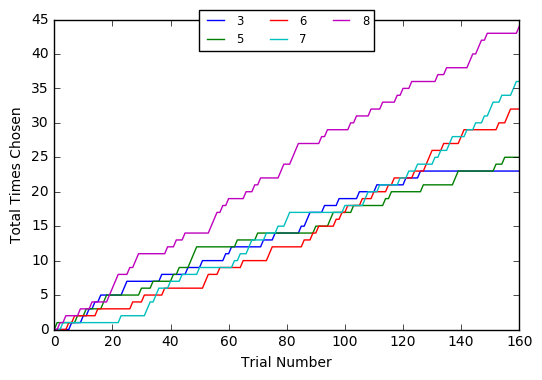

In [164]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

line_1, = plt.plot(options[0], label='3')
line_2, = plt.plot(options[1], label='5')
line_3, = plt.plot(options[2], label='6')
line_4, = plt.plot(options[3], label='7')
line_5, = plt.plot(options[4], label='8')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3,  handles=[line_1, line_2, line_3, line_4, line_5], prop = fontP)
plt.xlabel('Trial Number')
plt.ylabel('Total Times Chosen')

In [ ]:
print

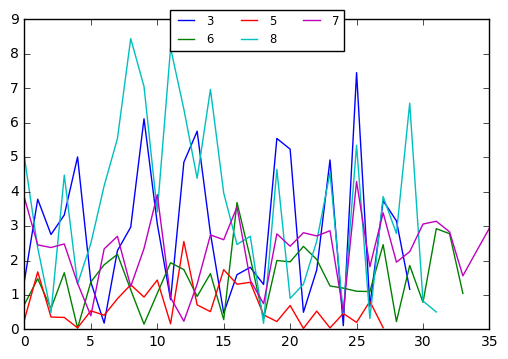

In [24]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

line_1, = plt.plot(group_errors[0], label='3')
line_2, = plt.plot(group_errors[1], label='6')
line_3, = plt.plot(group_errors[2], label='5')
line_4, = plt.plot(group_errors[3], label='8')
line_5, = plt.plot(group_errors[4], label='7')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3,  handles=[line_1, line_2, line_3, line_4, line_5], prop = fontP)
